# MACHINE LEARNING - PROJECT 1

### import libraries

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### constants

In [2]:
#constants definitions
PRI_JET_NUM_IDX = 22   
PRI_JET_NUM_VALUES = range(4)
NUMBER_GROUPS = len(PRI_JET_NUM_VALUES)
NBR_FEATURES = 30
UNDEFINED_VALUE = -999.

### load the training data into feature matrix, class labels and event ids

In [3]:
%%time
# Load train data and supply path
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

CPU times: user 8.28 s, sys: 488 ms, total: 8.77 s
Wall time: 8.83 s


### correlation matrix of the features before data processing

<AxesSubplot:>

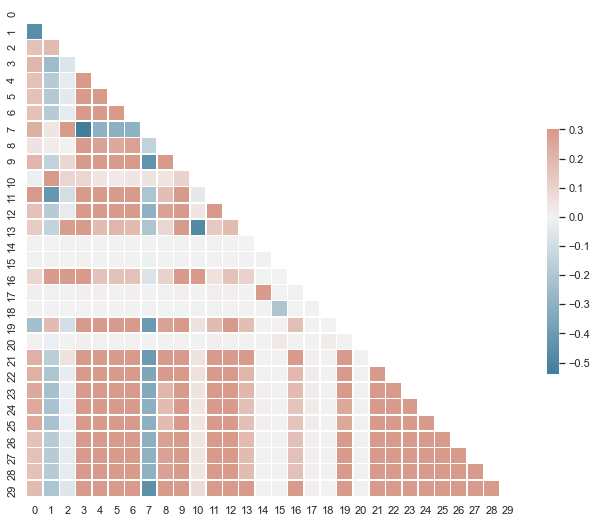

In [4]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=tX)

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### statistics about the distribution of undefined values

In [5]:
# Get some info about the data and undefined values
nbr_samples = tX.shape[0]
nbr_samples_with_undefined_features = 0
nbr_undefined_features = 0
nbr_features = tX.shape[0] * tX.shape[1]

for line_idx in range(tX.shape[0]):
    contains_undefined_feature = False
    for column_idx in range(len(tX[line_idx])):
        if tX[line_idx][column_idx] == UNDEFINED_VALUE:
            contains_undefined_feature = True
            nbr_undefined_features += 1
    if contains_undefined_feature:
          nbr_samples_with_undefined_features += 1

print(f"total number of samples : {nbr_samples}")
print(f"number of samples with undefined features : {nbr_samples_with_undefined_features}")
print(f"proportion of samples with undefined features : {nbr_samples_with_undefined_features / nbr_samples}")

print(f"\ntotal number of features : {nbr_features}")
print(f"total number undefined features : {nbr_undefined_features}")
print(f"proportion of undefined features : {nbr_undefined_features / nbr_features }")

total number of samples : 250000
number of samples with undefined features : 181886
proportion of samples with undefined features : 0.727544

total number of features : 7500000
total number undefined features : 1580052
proportion of undefined features : 0.2106736


### feature engineering and data processing

In [6]:
#seperating the data within the four groups (with respect to the jet_number)
jet_groups_indices = [tX[:, PRI_JET_NUM_IDX] == pri_jet_num_value for pri_jet_num_value in PRI_JET_NUM_VALUES]
TX_arr = [tX[group_indices] for group_indices in jet_groups_indices]
Y_arr, TX_arr = zip(*[(y[group_indices], tX[group_indices]) for group_indices in jet_groups_indices])
Y_arr, TX_arr = list(Y_arr), list(TX_arr)

#collecting the indices of the undefined features for each group
undefined_features = [[], [], [], []]
for group_idx in range(NUMBER_GROUPS):
    tx = TX_arr[group_idx]
    for feature_idx in range(NBR_FEATURES):
        feature_column = tx[:, feature_idx]
        if np.all(feature_column == UNDEFINED_VALUE):
            undefined_features[group_idx].append(feature_idx)

#computing the std of the features for each group
STDS = [np.std(TX_arr[i], axis = 0) for i in range(NUMBER_GROUPS)]

#collecting the indices of the features with no variance (i.e. constant features) within each groups
cst_features = [[], [], [], []]
for group_idx, elem in enumerate(STDS):
    for feature_idx, std in enumerate(elem):
        if std == 0. and feature_idx not in undefined_features[group_idx]:
            cst_features[group_idx].append(feature_idx)

#deleting the features either undefined or with no variance (i.e. constant features) within each groups
features_to_keep = ([[x for x in range(NBR_FEATURES)
                      if x not in undefined_features[group_idx] and x not in cst_features[group_idx]]
                      for group_idx in range(NUMBER_GROUPS)])
TX_arr = [TX_arr[group_idx][:, features_to_keep[group_idx]] for group_idx in range(NUMBER_GROUPS)]

#computing the median of each feature and substituting it instead of undefined values
train_medians = []
for group_idx in range(NUMBER_GROUPS):
    medians = np.apply_along_axis(lambda v: np.median(v[v!=UNDEFINED_VALUE]), 0, TX_arr[group_idx])
    train_medians.append(medians)
    for col_num in range(TX_arr[group_idx].shape[1]):
        column = TX_arr[group_idx][:, col_num]
        column[column == UNDEFINED_VALUE] = medians[col_num]

#standardizing the data
#TX_arr = [standardize(TX_arr[idx]) for idx in range(NUMBER_GROUPS)]


#applying a logarithmic transformation to the data
for group_idx in range(NUMBER_GROUPS):
    for idx_line in range(TX_arr[group_idx].shape[0]):
        for idx_col in range(TX_arr[group_idx].shape[1]):
            if TX_arr[group_idx][idx_line][idx_col] == 0:
                TX_arr[group_idx][idx_line][idx_col] = np.log(1e-6)
            elif TX_arr[group_idx][idx_line][idx_col] < 0:
                TX_arr[group_idx][idx_line][idx_col] = - np.log(-TX_arr[group_idx][idx_line][idx_col])
            else:
                TX_arr[group_idx][idx_line][idx_col] = np.log(TX_arr[group_idx][idx_line][idx_col])

In [7]:
# Print the remaining number of features for each JET NUMBER
for i in PRI_JET_NUM_VALUES:
    print(f"Number of features for group {i} : ", len(features_to_keep[i]))
    
# The column numbers of the features to keep
print(features_to_keep[0])
print(features_to_keep[1])
print(features_to_keep[2])
print(features_to_keep[3])

Number of features for group 0 :  18
Number of features for group 1 :  22
Number of features for group 2 :  29
Number of features for group 3 :  29
[0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29]


### least squares with gradient descent

In [ ]:
%%time

gammas = np.logspace(-6, -2, 5)
max_iters = 10_000

# Iterate over some gammas to find the best possible values
for gamma in gammas:
    print(f"Gamma = {gamma}")
    
    # Iterate over all jet numbers dataframes
    for i in range(len(features_to_keep)):
        initial_w = np.zeros(len(features_to_keep[i]))
        y = Y_arr[i]
        tx = TX_arr[i]
        weights, loss = least_squares_GD(y, tx, initial_w, max_iters, gamma)
        print(f"    For JET_NB {i}, the obtained loss is {loss}")

### least squares with stochastic gradient descent

In [ ]:
%%time

gammas = np.logspace(-6, -2, 5)
max_iters = 10_000
batch_size = 1

# Iterate over some gammas to find the best possible values
for gamma in gammas:
    print(f"Gamma = {gamma}")
    
    # Iterate over all jet numbers dataframes
    for i in range(len(features_to_keep)):
        initial_w = np.zeros(len(features_to_keep[i]))
        y = Y_arr[i]
        tx = TX_arr[i]
        weights, loss = least_squares_SGD(y, tx, initial_w, batch_size, max_iters, gamma)
        print(f"    For JET_NB {i}, the obtained loss is {loss:>15}")

### least squares

In [ ]:
for i in range(len(features_to_keep)):
    initial_w = np.zeros(len(features_to_keep[i]))
    y = Y_arr[i]
    tx = TX_arr[i]
    weights, loss = least_squares(y, tx)
    print(f"For JET_NB {i}, the obtained loss is {loss}")

### ridge regression

In [ ]:
%%time

seed = 15
degrees = range(1, 9)
k_fold = 4
lambdas = np.logspace(-17, -8, 30)
PARAM_arr = []

for group_idx in range(NUMBER_GROUPS):
    degree, lambda_ = cross_validation_demo_ridge(Y_arr[group_idx], TX_arr[group_idx], seed, degrees, k_fold, lambdas)
    PARAM_arr.append((degree, lambda_))
    print(f" ---> for group {group_idx}, the best degree is {degree} and lambda is {lambda_}")

In [ ]:
#training model and generating the predictions for each group
y_pred = np.empty(tX_test.shape[0])
for group_idx in range(NUMBER_GROUPS):
    #training
    tx_train = build_poly(TX_arr[group_idx], PARAM_arr[group_idx][0])
    y_train = Y_arr[group_idx]
    lambda_ = PARAM_arr[group_idx][1]
    weight, loss = ridge_regression(y_train, tx_train, lambda_)

### logistic regression

In [ ]:
%%time

seed = 15
max_iters = 10_000
degrees = range(1, 9)
k_fold = 4
gammas = np.logspace(-17, -8, 30)

for i in range(NUMBER_GROUPS):
    y = Y_arr[i]
    y[y == - 1.0] = 0.0
    tx = TX_arr[i]
    degree, gamma, rmse_min = cross_validation_demo_logistic(y, tx, max_iters, seed, degrees, k_fold, gammas)
    print(f"For JET_NB {i}, the obtained best degree is {degree} and gamma is {gamma} and loss is {rmse_min}")

### regularized logistic regression

In [ ]:
%%time

seed=15
degrees=[1, 2, 6]
k_fold=4
max_iters=10_000
lambdas = np.logspace(-4, 0, 6)
gammas = np.logspace(-6, -2, 5)
    
params = []

for idx in range(4):
    y=np.array(Y_arr[idx])
    y[y == - 1.0] = 0.0
    tX=np.array(TX_arr[idx])
    initial_w = np.zeros(len(features_to_keep[idx]))
    tuple_ = cross_validation_demo_reg_logistic(y, tX, max_iters, seed, degrees, k_fold, lambdas, gammas)
    params.append(tuple_)
    print("group ",idx, " tuple : ", tuple_)

### load the testing data into feature matrix, class labels and event ids

In [8]:
%%time

#loading the test data
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

#seperating the data within the four groups (with respect to the jet_number)
jet_groups_indices_test = [tX_test[:, PRI_JET_NUM_IDX] == pri_jet_num_value for pri_jet_num_value in PRI_JET_NUM_VALUES]
TX_test_arr = list([tX_test[group_indices] for group_indices in jet_groups_indices_test])

#removing unused features (using the indices found during the processing of the training data)
TX_test_arr = [TX_test_arr[group_idx][:, features_to_keep[group_idx]] for group_idx in range(NUMBER_GROUPS)]

#replacing the the undefined values by the median of the corresponding feature
for group_idx in range(NUMBER_GROUPS):
    for col_num in range(TX_test_arr[group_idx].shape[1]):
        column = TX_test_arr[group_idx][:, col_num]
        column[column == UNDEFINED_VALUE] = train_medians[group_idx][col_num]

#standardizing the data
#TX_test_arr = [standardize(TX_test_arr[idx]) for idx in range(NUMBER_GROUPS)]

#applying a logarithmic transformation to the data
for group_idx in range(NUMBER_GROUPS):
    for idx_line in range(TX_test_arr[group_idx].shape[0]):
        for idx_col in range(TX_test_arr[group_idx].shape[1]):
            if TX_test_arr[group_idx][idx_line][idx_col] == 0:
                TX_test_arr[group_idx][idx_line][idx_col] = np.log(1e-6)
            elif TX_test_arr[group_idx][idx_line][idx_col] < 0:
                TX_test_arr[group_idx][idx_line][idx_col] = - np.log(-TX_test_arr[group_idx][idx_line][idx_col])
            else:
                TX_test_arr[group_idx][idx_line][idx_col] = np.log(TX_test_arr[group_idx][idx_line][idx_col])

CPU times: user 1min 8s, sys: 2.26 s, total: 1min 10s
Wall time: 1min 11s


<AxesSubplot:>

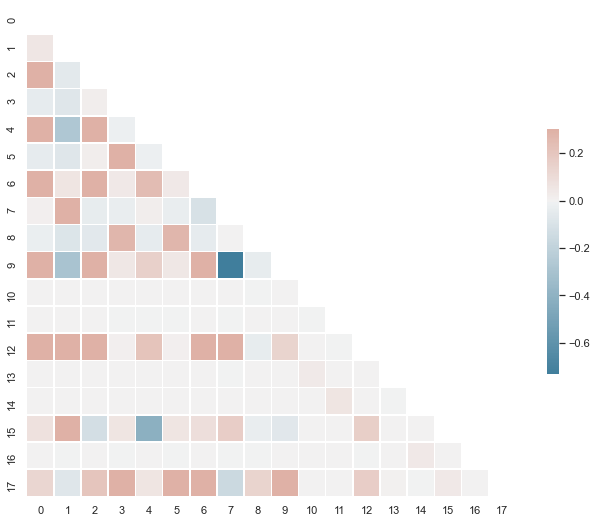

In [13]:
import pandas as pd
import seaborn as sns

# Number of the subset
index = 0

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=TX_test_arr[index])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### create csv file with predictions

In [ ]:
#creating csv file
OUTPUT_PATH = '../data/sample-submission.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)